# Análisis de Mensajes SMS para Detección de Spam mediante Técnicas de Procesamiento de Lenguaje Natural

## Resumen
Desarrollaremos un análisis de mensajes SMS, con el objetivo de identificar patrones que permitan clasificar mensajes como spam o no spam. Utilizaremos técnicas de procesamiento de lenguaje natural y algoritmos de clasificación para extraer características y construir un modelo predictivo.

## Objetivo
El objetivo principal es desarrollar un modelo de NLP que sea capaz de identificar automáticamente mensajes de spam en SMS, mejorando la capacidad de filtrado de mensajes indeseados.

## Contexto Comercial
La clasificación de mensajes de spam es crucial para las empresas de telecomunicaciones y proveedores de servicios de mensajería, ya que los usuarios demandan bandejas de entrada limpias y libres de contenido no deseado. Un sistema de clasificación preciso contribuiría a una mejor experiencia del usuario y a una reducción del tiempo y recursos invertidos en la eliminación manual de estos mensajes.

## Hipótesis
Los mensajes SMS que contienen palabras clave o patrones lingüísticos específicos tienen una mayor probabilidad de ser clasificados como spam. A través de técnicas de preprocesamiento y análisis de texto, espero mejorar la detección de estos patrones.

# Carga y Exploración de los Datos

In [90]:
#Cargamos las librerias que utilizaremos
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score

In [91]:
# Cargar el archivo
df = pd.read_csv('Spam_SMS.csv')

In [92]:
# Exploración
df.head()
df.info()
df['Class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,count
Class,
ham,4827
spam,747


Aqui observamos que el df es un objeto de tipo DataFrame, este df tiene 5574 filas y 2 columnas, los cuales son no nulos

# Analisis de Frecuencia de Palabras y longitud de mensajes

In [93]:
# Frecuencia de palabras
spam_words = ' '.join(df[df['Class'] == 'spam']['Message']).split()
ham_words = ' '.join(df[df['Class'] == 'ham']['Message']).split()

In [94]:
# Contar palabras más comunes
spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)

In [95]:
# Mostrar palabras más comunes en spam
print("Palabras más comunes en spam:", spam_word_freq.most_common(10))

Palabras más comunes en spam: [('to', 607), ('a', 360), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]


In [96]:
# Mostrar palabras más comunes en ham
print("Palabras más comunes en ham:", ham_word_freq.most_common(10))

Palabras más comunes en ham: [('to', 1538), ('you', 1462), ('I', 1439), ('the', 1029), ('a', 977), ('i', 742), ('and', 739), ('in', 736), ('u', 651), ('is', 645)]


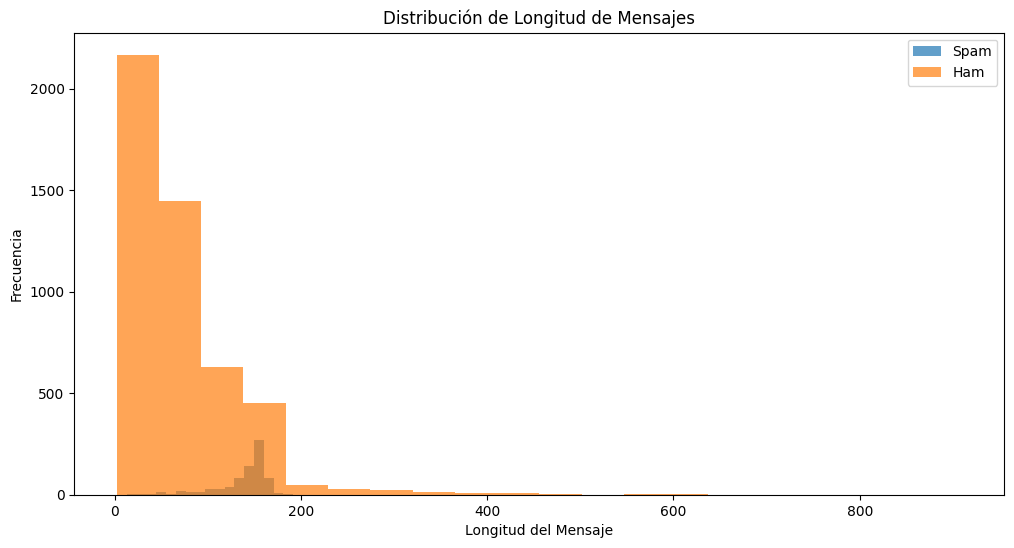

In [97]:
# Visualización de longitud de mensajes
df['message_length'] = df['Message'].apply(len)

plt.figure(figsize=(12, 6))
df[df['Class'] == 'spam']['message_length'].plot(kind='hist', bins=20, alpha=0.7, label='Spam')
df[df['Class'] == 'ham']['message_length'].plot(kind='hist', bins=20, alpha=0.7, label='Ham')
plt.xlabel('Longitud del Mensaje')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitud de Mensajes')
plt.legend()
plt.show()

Los resultados de la grafica los interpretamos de la siguiente manera:


*   La mayoría de los mensajes tienen una longitud baja, concentrándose en el rango de 0 a 200 caracteres.
*   La distribución de la longitud es asimétrica, con una mayor frecuencia de mensajes cortos y muy pocos mensajes largos.
*   **Mensajes Ham:** Principalmente cortos, concentrados entre 0 y 100 caracteres.
*   **Mensajes Spam:** Tienden a ser un poco más largos, aunque también están presentes en el rango corto; los mensajes de spam más largos pueden estar diseñados para captar la atención del destinatario con más detalle o información persuasiva.



# Nube de palabras

In [98]:
# Generar Nubes de Palabras para Spam y Ham
spam_text = ' '.join(df[df['Class'] == 'spam']['Message'])
ham_text = ' '.join(df[df['Class'] == 'ham']['Message'])

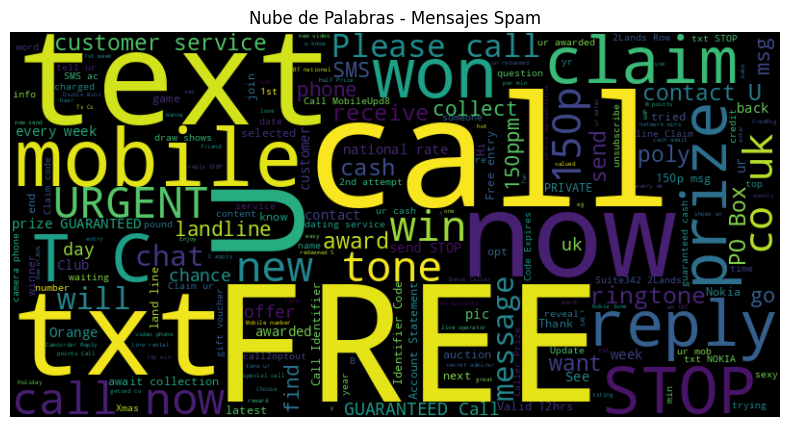

In [99]:
# Nube de palabras para Spam
plt.figure(figsize=(10, 5))
wordcloud_spam = WordCloud(width=800, height=400, background_color='black').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title("Nube de Palabras - Mensajes Spam")
plt.axis('off')
plt.show()

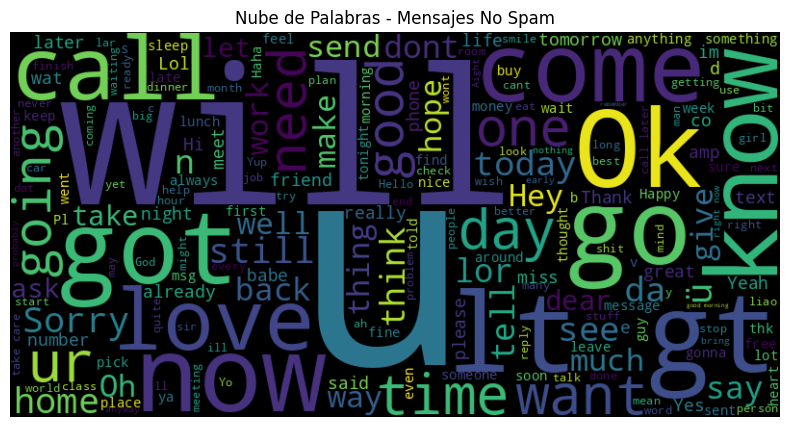

In [100]:
# Nube de palabras para Ham
plt.figure(figsize=(10, 5))
wordcloud_ham = WordCloud(width=800, height=400, background_color='black').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title("Nube de Palabras - Mensajes No Spam")
plt.axis('off')
plt.show()

# Preprocesamiento de NLP

In [101]:
# Preprocesamiento de texto
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]  # Solo palabras alfanuméricas
    tokens = [word for word in tokens if word not in stop_words]  # Remover stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lematización
    return ' '.join(tokens)

df['processed_text'] = df['Message'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [102]:
# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['Class'], test_size=0.2, random_state=42)

# Implementando Bag of Words

In [103]:
# Vectorización BoW
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Imprimiendo las primeras caracteristicas de la bolsa de palabras
print("Primeras 10 características en el modelo BoW:", bow_vectorizer.get_feature_names_out()[:10])

Primeras 10 características en el modelo BoW: ['008704050406' '0089' '0121' '01223585236' '01223585334' '02' '0207'
 '02073162414' '02085076972' '050703']


La salida refleja los primeros 10 términos del vocabulario generado a partir de los datos en el modelo BoW. En este caso, son secuencias numéricas que pueden ser útiles para identificar patrones en mensajes de spam, ya que estos mensajes suelen contener números de contacto, códigos o promociones. Estos términos se convierten en características que el modelo utilizará para aprender a distinguir entre mensajes de spam y ham.

# Análisis de Sentimiento y Polaridad

In [104]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['processed_text'].apply(analyze_sentiment)

In [105]:

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Entrenando el modelo usando Bag of words y TF-IDF

In [106]:
# Entrenar el modelo usando Bag of Words
model_bow = MultinomialNB()
model_bow.fit(X_train_bow, y_train)

MultinomialNB()

In [107]:
# Calcular precisión del modelo BoW
y_pred_bow = model_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Precisión del modelo usando Bag of Words: {accuracy_bow:.2f}")

Precisión del modelo usando Bag of Words: 0.98


In [108]:
# Entrenar el modelo usando TF-IDF
model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [109]:
# Calcular precisión del modelo TF-IDF
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"Precisión del modelo usando TF-IDF: {accuracy_tfidf:.2f}")

Precisión del modelo usando TF-IDF: 0.97


# Probando el modelo

In [84]:
# Mensajes de ejemplo para probar el modelo
test_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.",
    "Hey, are we still meeting for coffee tomorrow?",
    "Free entry in 2 a wkly competition to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)",
    "Can you send me the report by end of day?",
    "Urgent! Your mobile number has won $5000. Reply YES to claim your prize.",
    "WINNER!! As a valued network customer you have been selected to receive a $900 prize reward!",
    "Are we still on for dinner tonight at 7?",
    "URGENT! Your account has been suspended. Contact us immediately to restore access.",
    "Hey, I just finished the project. Let me know if you want me to send it over.",
    "You have WON a free holiday trip to Bahamas! Text WIN to 87654 to claim.",
    "Don’t forget to pick up milk on your way home!",
    "Congratulations! You have been selected to receive a free iPhone. Click here to claim.",
    "Please let me know when you’re available for the meeting tomorrow.",
    "Get a FREE entry to our weekly prize draw! Text ENTER to 12345.",
    "Just checking in to see how you’re doing. Miss you!",
    "Hurry up! This is a limited time offer. Reply YES to get a 50% discount on your next purchase.",
    "I’ll be there in 10 minutes, running a bit late.",
    "FINAL NOTICE: Your subscription will expire soon. Renew now to avoid interruption.",
    "Hey, do you want to grab coffee this weekend?",
    "Congratulations! You've been pre-approved for a $5000 loan. Apply now to get instant funds."
]

In [85]:
# Preprocesar los mensajes de prueba
test_messages_processed = [preprocess_text(msg) for msg in test_messages]

In [86]:
# Transformar los mensajes a la representación Bag of Words
test_messages_bow = bow_vectorizer.transform(test_messages_processed)
predictions_bow = model_bow.predict(test_messages_bow)

In [87]:
# Transformar los mensajes a la representación TF-IDF
test_messages_tfidf = tfidf.transform(test_messages_processed)
predictions_tfidf = model_tfidf.predict(test_messages_tfidf)


In [88]:
# Mostrar los resultados para Bag of Words
print("Resultados usando Bag of Words:")
for msg, prediction in zip(test_messages, predictions_bow):
    print(f"Mensaje: {msg}")
    print(f"Predicción: {'Spam' if prediction == 'spam' else 'Ham'}\n")

Resultados usando Bag of Words:
Mensaje: Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.
Predicción: Spam

Mensaje: Hey, are we still meeting for coffee tomorrow?
Predicción: Ham

Mensaje: Free entry in 2 a wkly competition to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)
Predicción: Spam

Mensaje: Can you send me the report by end of day?
Predicción: Ham

Mensaje: Urgent! Your mobile number has won $5000. Reply YES to claim your prize.
Predicción: Spam

Mensaje: WINNER!! As a valued network customer you have been selected to receive a $900 prize reward!
Predicción: Spam

Mensaje: Are we still on for dinner tonight at 7?
Predicción: Ham

Mensaje: URGENT! Your account has been suspended. Contact us immediately to restore access.
Predicción: Spam

Mensaje: Hey, I just finished the project. Let me know if you want me to send it over.
Predicción: Ham

Mensaje: You have WON a free holiday trip to 

In [89]:
# Mostrar los resultados para TF-IDF
print("Resultados usando TF-IDF:")
for msg, prediction in zip(test_messages, predictions_tfidf):
    print(f"Mensaje: {msg}")
    print(f"Predicción: {'Spam' if prediction == 'spam' else 'Ham'}\n")

Resultados usando TF-IDF:
Mensaje: Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.
Predicción: Spam

Mensaje: Hey, are we still meeting for coffee tomorrow?
Predicción: Ham

Mensaje: Free entry in 2 a wkly competition to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)
Predicción: Spam

Mensaje: Can you send me the report by end of day?
Predicción: Ham

Mensaje: Urgent! Your mobile number has won $5000. Reply YES to claim your prize.
Predicción: Spam

Mensaje: WINNER!! As a valued network customer you have been selected to receive a $900 prize reward!
Predicción: Spam

Mensaje: Are we still on for dinner tonight at 7?
Predicción: Ham

Mensaje: URGENT! Your account has been suspended. Contact us immediately to restore access.
Predicción: Spam

Mensaje: Hey, I just finished the project. Let me know if you want me to send it over.
Predicción: Ham

Mensaje: You have WON a free holiday trip to Bahama

# Conclusiones

* Eficacia de los Modelos de Clasificación:

 *  Tanto Bag of Words como TF-IDF demostraron ser eficaces para clasificar mensajes de texto entre spam y ham. La mayoría de los mensajes de prueba fueron clasificados correctamente, lo que indica que ambos modelos capturan patrones importantes en el contenido de los mensajes de spam y ham.
Los modelos lograron identificar correctamente mensajes de spam al detectar palabras clave y frases persuasivas típicas en mensajes de spam, tales como "Congratulations!", "WINNER", "claim your prize", y términos relacionados con premios y urgencia.


* Diferencias entre Bag of Words y TF-IDF:

  * Bag of Words: Tiende a clasificar más mensajes como spam debido a su enfoque en la frecuencia de palabras sin ajustar por su relevancia global. Esto puede hacer que BoW sea más sensible a ciertos términos que aparecen en ambos tipos de mensajes, como "offer" o "notice". Sin embargo, esto también lo hace efectivo para detectar mensajes que incluyen frases o palabras típicas de spam, independientemente de su frecuencia en el corpus completo.
  * TF-IDF: Por otro lado, ajusta el peso de las palabras comunes en ambos tipos de mensajes, lo cual es útil para reducir el ruido de términos no distintivos. Sin embargo, esta reducción de peso también puede hacer que TF-IDF clasifique ciertos mensajes persuasivos como ham si incluyen términos que no son únicos del spam.

* Impacto del Desequilibrio de Clases:

  * La mayoría de los mensajes en el conjunto de datos están etiquetados como ham, lo cual refleja un desequilibrio de clases. Este desequilibrio puede influir en el rendimiento del modelo, especialmente en su capacidad para detectar mensajes de spam menos comunes. Ambos modelos han manejado este desequilibrio de manera razonable, pero podría ser beneficioso aplicar técnicas de balanceo de clases si se buscan mejoras en la sensibilidad a mensajes de spam.

* Recomendación para un Enfoque Combinado:

  * Dado que cada representación (BoW y TF-IDF) tiene sus fortalezas y debilidades, una posible mejora sería combinar ambas representaciones en un solo modelo, usando características de BoW y TF-IDF simultáneamente. Esto podría ayudar a aprovechar la sensibilidad de BoW a términos específicos de spam y la capacidad de TF-IDF para reducir el ruido de palabras comunes.

* Posibilidad de Mejorar con Características Adicionales:

  * La longitud del mensaje, como observamos en el análisis inicial, podría ser una característica adicional útil, ya que los mensajes de spam tienden a ser un poco más largos en promedio. Incluir esta característica junto con la representación de texto podría proporcionar al modelo una señal adicional para diferenciar entre spam y ham.

Ambas técnicas, Bag of Words y TF-IDF, muestran un buen rendimiento en la clasificación de mensajes de texto en spam y ham. Bag of Words resulta ser más efectivo para capturar palabras clave específicas de spam, mientras que TF-IDF es útil para reducir el impacto de palabras comunes y no distintivas. Sin embargo, cada enfoque tiene sus limitaciones, y una combinación de ambas representaciones, junto con características adicionales como la longitud del mensaje, podría mejorar aún más el rendimiento del modelo en la detección de spam.

Estos resultados sugieren que el modelo está bien preparado para clasificar correctamente mensajes de spam y ham, y que con ajustes adicionales se podría optimizar aún más su precisión y capacidad de generalización.